# Lagrangian analyses of trajectories

Using the sitrack tool of Laurent Brodeau (https://github.com/brodeau/sitrack), we seed virtual buoys at the same position as the IABP ones and then advect them with our simulation velocity fields. 

This notebook aims at analysing the trajectories of these virtual buoys. In the first part, we compare the simulated trajectories with real ones (IABP data) in order to assess the realism of the model we use. Then we look at the evolution of the spread of the simulated trajectories over time. 

Some functions used here come from the homemade Python packages: lib4traj.py, libellipse.py and libfig.py. So, make sure to install Python_library library and that Python is able to locate it: put **export PYTHONPATH=<path_to_Python_library\>:${PYTHONPATH}** in your .bashrc, .profile or equivalent.

We also use the function for computing angles of the sitrack Python package. So, make sure to install the sitrack package before running the notebook. Furthermore, this line must appear in the .bashrc, .profile or equivalent file of the used machine in order to enable Python to locate the modules: **export PYTHONPATH=<absolute_path_to_somewhere\>:${PYTHONPATH}** with <absolute_path_to_somewhere\> the path to the localisation of the sitrack package.

In [1]:
#Importation of the different libraries

##Loading of NetCDF files
import xarray as xr

##Computing
import numpy as np
import lib4traj
import libellipse
import sitrack as sit

###Projection
import cartopy.crs as ccrs

##Graphical display
import libfig
import matplotlib.pyplot as plt

Name: libensdiv
Package: 
This is a collection of diverse functions for ensemble.
Name: lib4traj
Package: 
This is a collection of divers functions to work with Lagrangian trajectories.
Name: libellipse
Package: 
This is a collection of functions relative to ellipses.
Name: libfig
Package: 
This is a collection of diverse functions for creating figures.


### Loading the data

In [2]:
#Definition of some useful variables to localise the data
path_perso_store="/lustre/fsstor/projects/rech/cli/udf71br/"
path_store_commun="/lustre/fsstor/projects/rech/cli/commun/"
rep_result_ArcticBLISS="Arctic-BLISS_LF/"
path_work_Laurep="/lustre/fswork/projects/rech/cli/udf71br/Laurines_work_Datlas/"
loc_IABP_files="IABP_buoys_related_files/Periods_files/"
name_sitrack_outputs_file="sitrack_outputs/"

In [3]:
#Definition of the experiments and periods of interest
period_interest=["19970116h00_19970126h00","19970126h00_19970205h00","19970205h00_19970215h00","19970215h00_19970225h00",\
                "19970225h00_19970307h00","19970307h00_19970317h00","19970317h00_19970327h00","19970327h00_19970406h00"]
exp_interest=["EBLKBBM001","EBLKBBM010","EBLKBBM050","EBLKEVP001","EBLKEVP010","EBLKEVP050"]
nb_mber=20 #number of members
print(period_interest,exp_interest,nb_mber)

['19970116h00_19970126h00', '19970126h00_19970205h00', '19970205h00_19970215h00', '19970215h00_19970225h00', '19970225h00_19970307h00', '19970307h00_19970317h00', '19970317h00_19970327h00', '19970327h00_19970406h00'] ['EBLKBBM001', 'EBLKBBM010', 'EBLKBBM050', 'EBLKEVP001', 'EBLKEVP010', 'EBLKEVP050'] 20


In [4]:
#Loading the IABP files
dat_IABP=[]
for period in period_interest: #iteration over the periods of interest
    path=path_perso_store+loc_IABP_files+"IABP_buoys_"+period+".nc" #path to the IABP files
    print(path)
    dat_IABP.append(xr.open_dataset(path,decode_times=True))
    print("//")
print(len(dat_IABP),dat_IABP)

/lustre/fsstor/projects/rech/cli/udf71br/IABP_buoys_related_files/Periods_files/IABP_buoys_19970116h00_19970126h00.nc
//
/lustre/fsstor/projects/rech/cli/udf71br/IABP_buoys_related_files/Periods_files/IABP_buoys_19970126h00_19970205h00.nc
//
/lustre/fsstor/projects/rech/cli/udf71br/IABP_buoys_related_files/Periods_files/IABP_buoys_19970205h00_19970215h00.nc
//
/lustre/fsstor/projects/rech/cli/udf71br/IABP_buoys_related_files/Periods_files/IABP_buoys_19970215h00_19970225h00.nc
//
/lustre/fsstor/projects/rech/cli/udf71br/IABP_buoys_related_files/Periods_files/IABP_buoys_19970225h00_19970307h00.nc
//
/lustre/fsstor/projects/rech/cli/udf71br/IABP_buoys_related_files/Periods_files/IABP_buoys_19970307h00_19970317h00.nc
//
/lustre/fsstor/projects/rech/cli/udf71br/IABP_buoys_related_files/Periods_files/IABP_buoys_19970317h00_19970327h00.nc
//
/lustre/fsstor/projects/rech/cli/udf71br/IABP_buoys_related_files/Periods_files/IABP_buoys_19970327h00_19970406h00.nc
//
8 [<xarray.Dataset>
Dimensions: 

In [5]:
#Loading sitrack outputs files

dat_buoys=[[[] for k in range(len(exp_interest))] for _ in range(len(period_interest))] #contains the sitrack outputs for each period, experiment and member
##The list will have the following structure: shape=(len(period_interest),len(exp_interest),nb_mber)

for iperiod in range(len(period_interest)): #iteration over the periods of interest
    period=period_interest[iperiod]
    rep_period=period[:8]+period[11:19]+str(int(period[19])-1)+"/" #name of the repertory of the period of interest
    for iexp in range(len(exp_interest)): #iteration over the experiments of interest
        exp=exp_interest[iexp]
        for imb in range(nb_mber): #iteration over the members
            mb=str(imb+1).zfill(3)
            path=path_store_commun+rep_result_ArcticBLISS+exp+"/"+rep_period+name_sitrack_outputs_file+"NEMO-SI3_NANUK4_"+mb+exp+"_tracking_sidfex_1h_"+period+"_10km.nc"
            print(path)
            dat_buoys[iperiod][iexp].append(xr.open_dataset(path,decode_times=True))
print(len(dat_buoys),len(dat_buoys[0]),len(dat_buoys[0][0]))

/lustre/fsstor/projects/rech/cli/commun/Arctic-BLISS_LF/EBLKBBM001/19970116_19970125/sitrack_outputs/NEMO-SI3_NANUK4_001EBLKBBM001_tracking_sidfex_1h_19970116h00_19970126h00_10km.nc
/lustre/fsstor/projects/rech/cli/commun/Arctic-BLISS_LF/EBLKBBM001/19970116_19970125/sitrack_outputs/NEMO-SI3_NANUK4_002EBLKBBM001_tracking_sidfex_1h_19970116h00_19970126h00_10km.nc
/lustre/fsstor/projects/rech/cli/commun/Arctic-BLISS_LF/EBLKBBM001/19970116_19970125/sitrack_outputs/NEMO-SI3_NANUK4_003EBLKBBM001_tracking_sidfex_1h_19970116h00_19970126h00_10km.nc
/lustre/fsstor/projects/rech/cli/commun/Arctic-BLISS_LF/EBLKBBM001/19970116_19970125/sitrack_outputs/NEMO-SI3_NANUK4_004EBLKBBM001_tracking_sidfex_1h_19970116h00_19970126h00_10km.nc
/lustre/fsstor/projects/rech/cli/commun/Arctic-BLISS_LF/EBLKBBM001/19970116_19970125/sitrack_outputs/NEMO-SI3_NANUK4_005EBLKBBM001_tracking_sidfex_1h_19970116h00_19970126h00_10km.nc
/lustre/fsstor/projects/rech/cli/commun/Arctic-BLISS_LF/EBLKBBM001/19970116_19970125/sitra

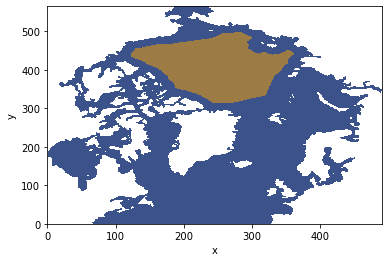

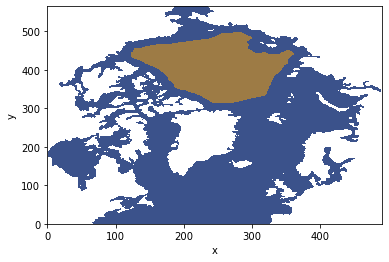

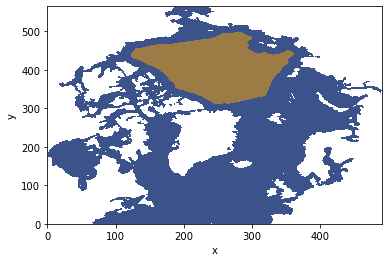

In [6]:
#Loading some masks

dat_masks=xr.open_dataset(path_store_commun+"NANUK4/NANUK4.L31-I/mesh_mask_NANUK4_L31_4.2_1stLev.nc") #masks of the configuration
dat_masks_domain=xr.open_dataset(path_work_Laurep+"Masks/masks_domain_threshold_0.5.nc") #masks of the domain of interest

##Visualisation of the configuration and domain masks

plt.contourf(dat_masks.tmask[0,0,:,:].where(dat_masks.tmask[0,0,:,:]>0))
plt.contourf(dat_masks_domain.tmask.where(dat_masks_domain.tmask>0),alpha=0.5,colors="orange")
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

plt.contourf(dat_masks.umask[0,0,:,:].where(dat_masks.umask[0,0,:,:]>0))
plt.contourf(dat_masks_domain.umask.where(dat_masks_domain.umask>0),alpha=0.5,colors="orange")
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

plt.contourf(dat_masks.vmask[0,0,:,:].where(dat_masks.vmask[0,0,:,:]>0))
plt.contourf(dat_masks_domain.vmask.where(dat_masks_domain.vmask>0),alpha=0.5,colors="orange")
plt.xlabel("x") ; plt.ylabel("y")
plt.show()

### Saving the dimensions of our data

In [7]:
#Saving the time and buoy dimension sizes of the sitrack outputs
size_time=dat_buoys[0][0][0].sizes["time"]
size_time_IABP=dat_IABP[0].sizes["time"]
size_buoy=[dat_buoys[iperiod][0][0].sizes["buoy"] for iperiod in range(len(period_interest))]
print(size_time_IABP,size_time,size_buoy)

81 241 [16, 15, 15, 13, 13, 10, 8, 11]


In [8]:
#Saving the time vector

time=[dat_buoys[iperiod][0][0].time.values for iperiod in range(len(period_interest))]
time_IABP=[dat_IABP[iperiod].time.values for iperiod in range(len(period_interest))]
print(len(time[0])==size_time,len(time_IABP[0])==size_time_IABP)

True True


In [9]:
#Other time vectors (in days since the seeding)

tdays_IABP=(time_IABP[0]-time_IABP[0][0])/np.timedelta64(1,'D')
tdays=(time[0]-time[0][0])/np.timedelta64(1,'D')

print("IABP ; begin: ",tdays_IABP[0],"end: ",tdays_IABP[-1],"25 first index: ",tdays_IABP[:26])
print("begin: ",tdays[0],"end: ",tdays[-1],"25 first index: ",tdays[:26])

IABP ; begin:  0.0 end:  10.0 25 first index:  [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    1.125 1.25  1.375
 1.5   1.625 1.75  1.875 2.    2.125 2.25  2.375 2.5   2.625 2.75  2.875
 3.    3.125]
begin:  0.0 end:  10.0 25 first index:  [0.         0.04166667 0.08333333 0.125      0.16666667 0.20833333
 0.25       0.29166667 0.33333333 0.375      0.41666667 0.45833333
 0.5        0.54166667 0.58333333 0.625      0.66666667 0.70833333
 0.75       0.79166667 0.83333333 0.875      0.91666667 0.95833333
 1.         1.04166667]


### Check if there are killed buoys or if all the buoys are alive over the period of simulation

In [10]:
#Check the number of buoys alive at the end of the period

for iperiod in range(len(period_interest)): #iteration over the periods of interest
    print("number of buoys for this period: ",size_buoy[iperiod])
    for iexp in range(len(exp_interest)): #iteration over the experiments of interest
        for imb in range(nb_mber): #iteration over the members
            print("number of buoys alive at the end: ",lib4traj.fbuoys_alive(dat_buoys[iperiod][iexp][imb])[0][-1].values,"\ killed buoys: ",lib4traj.fbuoys_alive(dat_buoys[iperiod][iexp][imb])[1])

number of buoys for this period:  16
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  16 \ killed buoys:  []
number of buoys alive at the end:  

### Some precomputations

#### Projection into a Cartesian frame

In [11]:
#Projection of the latitude and longitude into a Cartesian frame (x and y are in kilometers)

##Initialisation of the lists

pos_IABP=[xr.DataArray(data=np.zeros((size_time_IABP,size_buoy[iperiod],2))+99999.99,dims=["time","buoy","xy"]) for iperiod in range(len(period_interest))] #will contain the x and y positions of the IABP buoys
##The list has the following structure: a sublist per period because the number of buoys is not the same for each period, 
##each sublist contains an array of the following structure: shape=(len(time),len(buoy),2)
##the first dimension corresponds to the time, the second to the buoys, and the third to the Cartesian positions (x,y) in km (in this order)

pos_simubuoys=[xr.DataArray(data=np.zeros((len(exp_interest),nb_mber,size_time,size_buoy[iperiod],2))+99999.99,dims=["exp","mb","time","buoy","xy"]) for iperiod in range(len(period_interest))] 
##This list will contain the x and y positions of the simulated buoys
##The list has the following structure: a sublist per period because the number of buoys is not the same for each period, 
##each sublist contains an array of the following structure: shape=(len(exp_interest),nb_mber,len(time),len(buoy),2)
##the first dimension corresponds to the experiment of interest, the second to the member of interest,
##the third to the time, the fourth to the buoys and the fifth to the Cartesian positions (x,y) in km (in this order)

print("IABP",len(pos_IABP))
print("simulated buoys",len(pos_simubuoys))

##Projection

for iperiod in range(len(period_interest)):#iteration over the periods of interest

    print(period_interest[iperiod])
    
    pos_IABP[iperiod][:,:,:]=lib4traj.projGeo2Cartesian(dat_IABP[iperiod].latitude.values,dat_IABP[iperiod].longitude.values)
    
    for iexp in range(len(exp_interest)):#iteration over the experiments of interest
        for imb in range(nb_mber):#iteration over the members
            
            pos_simubuoys[iperiod][iexp,imb,:,:,:]=lib4traj.projGeo2Cartesian(dat_buoys[iperiod][iexp][imb].latitude.values,dat_buoys[iperiod][iexp][imb].longitude.values) #projection

    print("shape IABP",np.shape(pos_IABP[iperiod]),"shape simubuoys",np.shape(pos_simubuoys[iperiod]))
    
print("IABP",len(pos_IABP),"simulated buoys",len(pos_simubuoys))

IABP 8
simulated buoys 8
19970116h00_19970126h00
shape IABP (81, 16, 2) shape simubuoys (6, 20, 241, 16, 2)
19970126h00_19970205h00
shape IABP (81, 15, 2) shape simubuoys (6, 20, 241, 15, 2)
19970205h00_19970215h00
shape IABP (81, 15, 2) shape simubuoys (6, 20, 241, 15, 2)
19970215h00_19970225h00
shape IABP (81, 13, 2) shape simubuoys (6, 20, 241, 13, 2)
19970225h00_19970307h00
shape IABP (81, 13, 2) shape simubuoys (6, 20, 241, 13, 2)
19970307h00_19970317h00
shape IABP (81, 10, 2) shape simubuoys (6, 20, 241, 10, 2)
19970317h00_19970327h00
shape IABP (81, 8, 2) shape simubuoys (6, 20, 241, 8, 2)
19970327h00_19970406h00
shape IABP (81, 11, 2) shape simubuoys (6, 20, 241, 11, 2)
IABP 8 simulated buoys 8


#### Computing the velocities and their components (along x- and y-axes) from the trajectories

In [12]:
#Computation of the distance (in km) travelled between two time steps for the simulated buoys 
#(equivalent to the velocity in km/h as we have 1h between two time steps)
# + computation of the components of the ice velocity (in km/h)

##Initialisation of the lists
Dist_km_trav_1h_simubuoys=[xr.DataArray(data=np.zeros((len(exp_interest),nb_mber,size_time,size_buoy[iperiod]))+99999.99,dims=["exp","mb","time","buoy"]) for iperiod in range(len(period_interest))] #equivalent to the velocity in km/h
Velo_ice_components_simubuoys=[xr.DataArray(data=np.zeros((len(exp_interest),nb_mber,size_time,size_buoy[iperiod],2))+99999.99,dims=["exp","mb","time","buoy","xy"]) for iperiod in range(len(period_interest))]

##Computation
for iperiod in range(len(period_interest)): #iteration over the periods of interest
    
    ##Checking the time step
    print("should be 1 everywhere: ",(time[iperiod][1:]-time[iperiod][:-1])/np.timedelta64(1,"h"))
    
    ##Distances and velocities equal 0 at the seeding instant
    Dist_km_trav_1h_simubuoys[iperiod][:,:,0,:]=0
    Velo_ice_components_simubuoys[iperiod][:,:,0,:,:]=0

    ##Computation of the distances and velocities for the other instants
    Dist_km_trav_1h_simubuoys[iperiod][:,:,1:,:]=lib4traj.fdistance(pos_simubuoys[iperiod][:,:,:-1,:,0].values,pos_simubuoys[iperiod][:,:,:-1,:,1].values,pos_simubuoys[iperiod][:,:,1:,:,0].values,pos_simubuoys[iperiod][:,:,1:,:,1].values)
    Velo_ice_components_simubuoys[iperiod][:,:,1:,:,0]=pos_simubuoys[iperiod][:,:,1:,:,0].values-pos_simubuoys[iperiod][:,:,:-1,:,0].values
    Velo_ice_components_simubuoys[iperiod][:,:,1:,:,1]=pos_simubuoys[iperiod][:,:,1:,:,1].values-pos_simubuoys[iperiod][:,:,:-1,:,1].values
    
    print(np.shape(Dist_km_trav_1h_simubuoys[iperiod]),np.shape(Velo_ice_components_simubuoys[iperiod]))
print(len(Dist_km_trav_1h_simubuoys),len(Velo_ice_components_simubuoys))

should be 1 everywhere:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(6, 20, 241, 16) (6, 20, 241, 16, 2)
should be 1 everywhere:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [13]:
#Computation of the distance (in km) travelled between two time steps for the IABP buoys 
# + computation of the ice velocity and its components (in km/h)

##How we take into account missing values##
#For the velocity: one missing value in position => 2 missing values in velocity
#For the distance: one missing value in position => 1 missing value in distance (after the missing value(s) in position, we compute the distance from the last known position)

#Initialisation of the lists
Dist_km_trav_3h_IABP=[xr.DataArray(data=np.zeros((size_time_IABP,size_buoy[iperiod]))+99999.99,dims=["time","buoy"]) for iperiod in range(len(period_interest))]
Velo_ice_norm_IABP=[xr.DataArray(data=np.zeros((size_time_IABP,size_buoy[iperiod]))+99999.99,dims=["time","buoy"]) for iperiod in range(len(period_interest))]
Velo_ice_components_IABP=[xr.DataArray(data=np.zeros((size_time_IABP,size_buoy[iperiod],2))+99999.99,dims=["time","buoy","xy"]) for iperiod in range(len(period_interest))]

delta_t_IABP=3. #time lag between two time steps

#Computation of the distances and velocities
for iperiod in range(len(period_interest)): #iteration over the periods of interest
    
    ##Checking of the time step
    print("should be 3 everywhere: ",(time_IABP[0][1:]-time_IABP[0][:-1])/np.timedelta64(1,"h"))
    
    ##Distances and velocities equal 0 at the seeding instant
    Dist_km_trav_3h_IABP[iperiod][0,:]=0
    Velo_ice_norm_IABP[iperiod][0,:]=0
    Velo_ice_components_IABP[iperiod][0,:,:]=0

    ##Computing the distances and velocities for the other instants
    Dist_km_trav_3h_IABP[iperiod][1:,:]=lib4traj.fdistance(pos_IABP[iperiod][:-1,:,0].values,pos_IABP[iperiod][:-1,:,1].values,pos_IABP[iperiod][1:,:,0].values,pos_IABP[iperiod][1:,:,1].values)
    Velo_ice_norm_IABP[iperiod][1:,:]=Dist_km_trav_3h_IABP[iperiod][1:,:]/delta_t_IABP
    Velo_ice_components_IABP[iperiod][1:,:,0]=(pos_IABP[iperiod][1:,:,0].values-pos_IABP[iperiod][:-1,:,0].values)/delta_t_IABP
    Velo_ice_components_IABP[iperiod][1:,:,1]=(pos_IABP[iperiod][1:,:,1].values-pos_IABP[iperiod][:-1,:,1].values)/delta_t_IABP

    ##Treatment of the missing values for the distance
    ib_missing_values=np.unique(np.where(np.isnan(Dist_km_trav_3h_IABP[iperiod])==1)[1]) #buoys that have missing values
    print(ib_missing_values)
    for ib in ib_missing_values: #iteration over the buoys with missing values
        gaps_info=lib4traj.ffind_gaps(dat_IABP[iperiod]["mask"][:,ib].values,time_IABP[iperiod]) #find where the missing values are
        print(dat_IABP[iperiod].id_buoy[ib].values,gaps_info)
        for ig in range(len(gaps_info[0])):#iteration over the gaps
            print(gaps_info[0][ig],gaps_info[1][ig],gaps_info[0][ig]-int(gaps_info[1][ig]//delta_t_IABP))
            Dist_km_trav_3h_IABP[iperiod][gaps_info[0][ig],ib]=lib4traj.fdistance(pos_IABP[iperiod][gaps_info[0][ig],ib,0].values,\
                                                                                  pos_IABP[iperiod][gaps_info[0][ig],ib,1].values,\
                                                                                  pos_IABP[iperiod][gaps_info[0][ig]-int(gaps_info[1][ig]//delta_t_IABP),ib,0].values,\
                                                                                  pos_IABP[iperiod][gaps_info[0][ig]-int(gaps_info[1][ig]//delta_t_IABP),ib,1].values)
    
    print(np.shape(Dist_km_trav_3h_IABP[iperiod]),np.shape(Velo_ice_norm_IABP[iperiod]),np.shape(Velo_ice_components_IABP[iperiod]))
print(len(Dist_km_trav_3h_IABP),len(Velo_ice_norm_IABP),len(Velo_ice_components_IABP))

should be 3 everywhere:  [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3.]
[0 8 9]
1066717987 (array([28, 32, 36, 40, 44, 47, 51]), [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0])
28 6.0 26
32 6.0 30
36 6.0 34
40 6.0 38
44 6.0 42
47 6.0 45
51 6.0 49
8057 (array([47]), [6.0])
47 6.0 45
8058 (array([19]), [6.0])
19 6.0 17
(81, 16) (81, 16) (81, 16, 2)
should be 3 everywhere:  [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3.]
[9]
9353 (array([56]), [6.0])
56 6.0 54
(81, 15) (81, 15) (81, 15, 2)
should be 3 everywhere:  [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3

#### Ellipses computation

In [14]:
#Computation of the ellipses characteristics 

proba_ellipse=0.95 #probability used to define the ellipses

##Initialisation of the list that will contain the ellipse characteristics
ellipse_carac=[xr.Dataset(data_vars=dict(mu=(["exp","time","buoy","xy"],np.zeros((len(exp_interest),size_time,size_buoy[iperiod],2))+9999.99),
                                         sigma=(["exp","time","buoy","xyl","xyc"],np.zeros((len(exp_interest),size_time,size_buoy[iperiod],2,2))+9999.99),
                                         eigvalue=(["exp","time","buoy","newdim"],np.zeros((len(exp_interest),size_time,size_buoy[iperiod],2))+9999.99),
                                         eigvector=(["exp","time","buoy","newdiml","newdimc"],np.zeros((len(exp_interest),size_time,size_buoy[iperiod],2,2))+9999.99),
                                         axlength=(["exp","time","buoy","newdim"],np.zeros((len(exp_interest),size_time,size_buoy[iperiod],2))+9999.99),
                                         angle=(["exp","time","buoy","newdim"],np.zeros((len(exp_interest),size_time,size_buoy[iperiod],2))+9999.99))) for iperiod in range(len(period_interest))]
print(len(ellipse_carac))

##Computation of the ellipse characteristics
for iperiod in range(len(period_interest)): #iteration over the periods of interest
    print(np.shape(ellipse_carac[iperiod].mu),np.shape(ellipse_carac[iperiod].sigma),\
          np.shape(ellipse_carac[iperiod].eigvalue),np.shape(ellipse_carac[iperiod].eigvector),\
         np.shape(ellipse_carac[iperiod].axlength),np.shape(ellipse_carac[iperiod].angle))
    for iexp in range(len(exp_interest)): #iteration over the experiments of interest
        for it in range(1,size_time): #iteration over time (do not compute the ellipse characteristics for the seeding instant)  
            for ib in range(size_buoy[iperiod]): #iteration over the buoys
                ellipse_carac[iperiod].mu[iexp,it,ib,:],ellipse_carac[iperiod].sigma[iexp,it,ib,:,:],ellipse_carac[iperiod].eigvalue[iexp,it,ib,:],\
                ellipse_carac[iperiod].eigvector[iexp,it,ib,:,:],ellipse_carac[iperiod].axlength[iexp,it,ib,:],ellipse_carac[iperiod].angle[iexp,it,ib,:]=\
                libellipse.fit_ellipse(pos_simubuoys[iperiod][iexp,:,it,ib,:].values,proba_ellipse)

8
(6, 241, 16, 2) (6, 241, 16, 2, 2) (6, 241, 16, 2) (6, 241, 16, 2, 2) (6, 241, 16, 2) (6, 241, 16, 2)
(6, 241, 15, 2) (6, 241, 15, 2, 2) (6, 241, 15, 2) (6, 241, 15, 2, 2) (6, 241, 15, 2) (6, 241, 15, 2)
(6, 241, 15, 2) (6, 241, 15, 2, 2) (6, 241, 15, 2) (6, 241, 15, 2, 2) (6, 241, 15, 2) (6, 241, 15, 2)


/lustre/fswork/projects/rech/cli/udf71br/Laurines_work_Datlas/python_lib/libellipse.py:64: RuntimeWarning: invalid value encountered in sqrt
  axlength=2*np.sqrt(qchi2*s) #total length the axes defined by each of the eigenvector


(6, 241, 13, 2) (6, 241, 13, 2, 2) (6, 241, 13, 2) (6, 241, 13, 2, 2) (6, 241, 13, 2) (6, 241, 13, 2)
(6, 241, 13, 2) (6, 241, 13, 2, 2) (6, 241, 13, 2) (6, 241, 13, 2, 2) (6, 241, 13, 2) (6, 241, 13, 2)
(6, 241, 10, 2) (6, 241, 10, 2, 2) (6, 241, 10, 2) (6, 241, 10, 2, 2) (6, 241, 10, 2) (6, 241, 10, 2)
(6, 241, 8, 2) (6, 241, 8, 2, 2) (6, 241, 8, 2) (6, 241, 8, 2, 2) (6, 241, 8, 2) (6, 241, 8, 2)
(6, 241, 11, 2) (6, 241, 11, 2, 2) (6, 241, 11, 2) (6, 241, 11, 2, 2) (6, 241, 11, 2) (6, 241, 11, 2)


To compute the ellipse characteristics, we made the hypothesis that the positions x and y follow a bivariate random law. In some cases, this hypothesis could be totally wrong, and the computation of ellipse characteristics will not work properly. To know if that happened, check the sign of the eigenvalues: they should be positive.

### Looking at the trajectories

['EBLKBBM001', 'EBLKBBM010', 'EBLKBBM050', 'EBLKEVP001', 'EBLKEVP010', 'EBLKEVP050'] [1, 4]
9 [19579 26695  8057  8058  9353  9354  9357  9358  9360  9361  9365]


[]

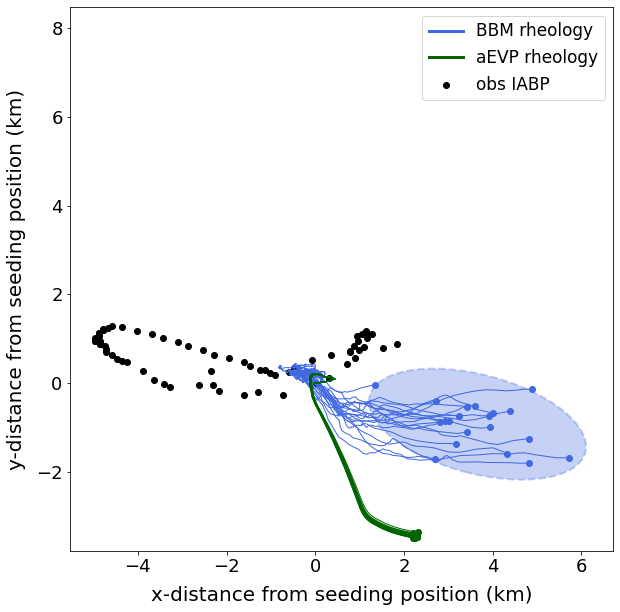

In [16]:
#Trajectory figure with both rheologies and one given initial amplitude of perturbation (comparison with the corresponding IABP trajectory)

##Definition of what interests us for this figure
    ##experiments of interest
atmos_interest="BLK"
std_interest="010"
exp_plot=[iexp for iexp in range(len(exp_interest)) if ((atmos_interest in exp_interest[iexp]) and (std_interest in exp_interest[iexp]))]
print(exp_interest, exp_plot)
    ##period of interest
iperiod=7
    #buoy of interest
buoy_interest=9361
ib=np.where(dat_IABP[iperiod].id_buoy==buoy_interest)[0][0]
print(ib,dat_IABP[iperiod].id_buoy.values)

##Creation of the figure

fig,ax=plt.subplots(1,1,figsize=(10,10))

    ##seeding position
pos_ini=pos_IABP[iperiod][0,ib,:]

for iexp in exp_plot: #iteration over the experiments of interest
    
    ##color and label associated with the experiment
    color,label=libfig.fgraph_attributesv2(exp_interest[iexp],"rheo",type_label="model",focus_model="rheo")
    label="a"*(exp_interest[iexp][-6:-3]=="EVP")+label+" rheology"

    for imb in range(nb_mber): #iteration over the members    
        label=""+label*(imb==0) #set up the label once

        ##Plot the trajectories
        ax.plot(pos_simubuoys[iperiod][iexp,imb,:,ib,0]-pos_ini[0],pos_simubuoys[iperiod][iexp,imb,:,ib,1]-pos_ini[1],label=label,color=color,lw=1,zorder=1)

        ##Plot a point at the end
        ax.scatter(pos_simubuoys[iperiod][iexp,imb,-1,ib,0]-pos_ini[0],pos_simubuoys[iperiod][iexp,imb,-1,ib,1]-pos_ini[1],color=color)

    ##Draw 95% ellipse at the end
    libellipse.draw_ellipse(ellipse_carac[iperiod].mu[iexp,-1,ib,:]-pos_ini,ellipse_carac[iperiod].axlength[iexp,-1,ib,:],\
                            ellipse_carac[iperiod].angle[iexp,-1,ib,:],ax,legend=False,edge_color=color,edge_width=2,edge_style="--",fill_color=color,alpha=0.3)


    ##Plot the observed positions of the associated IABP buoy
ax.scatter(pos_IABP[iperiod][:,ib,0]-pos_ini[0],pos_IABP[iperiod][:,ib,1]-pos_ini[1],c="black",label="obs IABP")

        ##if there are any, making the gaps visible
gaps_info=lib4traj.ffind_gaps(dat_IABP[iperiod]["mask"][:,ib].values,time_IABP[iperiod])
for ig in range(len(gaps_info[0])):
    igap=gaps_info[0][ig]
    ax.scatter(pos_IABP[iperiod][igap,ib,0]-pos_ini[0],pos_IABP[iperiod][igap,ib,1]-pos_ini[1],c="black",edgecolors="red")
    ax.text(pos_IABP[iperiod][igap,ib,0]-pos_ini[0]+0.5,pos_IABP[iperiod][igap,ib,1]-pos_ini[1]+0.5,"+ "+str(gaps_info[1][ig])+"h",\
            color="red",fontsize=12,fontweight="bold")

    ##Set up the legend
leg=ax.legend(fontsize=17,ncol=1,columnspacing=0.5)
for line in leg.get_lines():
    line.set_linewidth(3.0)

    ##Set up the axes
ax.tick_params(axis="both",labelsize=18)

ax.set_ylabel("y-distance from seeding position (km)",fontsize=20,labelpad=10)
ax.set_xlabel("x-distance from seeding position (km)",fontsize=20,labelpad=10)

ax.axis('square')

plt.plot()

    ##Saving the figure (change the path if needed)
#fig.savefig("/lustre/fsn1/projects/rech/cli/udf71br/figures_traj_new_exp/Traj_buoy"+str(dat_IABP[iperiod].id_buoy[ib].values)+"_"+period_interest[iperiod]+"_"+atmos_interest+"_std"+std_interest+"_varticle.png",\
#            facecolor="white",edgecolor="none",bbox_inches="tight")

To work we should have 2 ==2
['EBLKBBM001', 'EBLKBBM010', 'EBLKBBM050', 'EBLKEVP001', 'EBLKEVP010', 'EBLKEVP050'] [[0, 1, 2], [3, 4, 5]]
7 [ 1101 19579 26695 26698 26699  8057  8058  9353  9354  9360]


[]

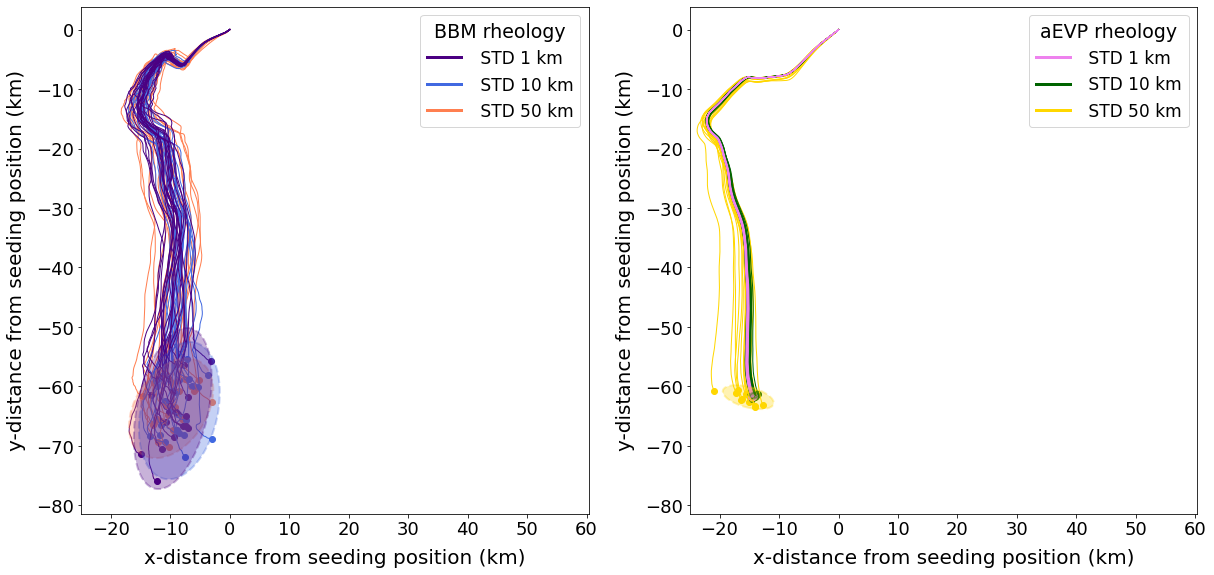

In [18]:
#Trajectory figure with one panel per rheology and all the initial amplitudes of perturbation

##Definition of what interests us for this figure
    ##experiments of interest
atmos_interest="BLK" ; rheo_possible=["BBM","EVP"]
print("To work we should have "+str(len(rheo_possible))+" ==2")
exp_plot=[[iexp for iexp in range(len(exp_interest)) if (atmos_interest+rheo_possible[irheo] in exp_interest[iexp])] for irheo in range(len(rheo_possible))]
print(exp_interest, exp_plot)
    ##period of interest
iperiod=5
    #buoy of interest
buoy_interest=9353
ib=np.where(dat_IABP[iperiod].id_buoy==buoy_interest)[0][0]
print(ib,dat_IABP[iperiod].id_buoy.values)

##Creation of the figure

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
axes=[ax1,ax2]

    ##seeding position
pos_ini=pos_IABP[iperiod][0,ib,:]

for iax in range(len(rheo_possible)): #iteration over the two rheologies
    for iexp in exp_plot[iax][::-1]: #iteration over the experiments of interest
    
        ##color and label associated with the experiment
        color,label=libfig.fgraph_attributesv2(exp_interest[iexp],"rheo",type_label="IC",focus_model="rheo")

        for imb in range(nb_mber): #iteration over the members    
            label=""+label[2:]*(imb==0) #set up the label only once

            ##Plot the trajectories
            axes[iax].plot(pos_simubuoys[iperiod][iexp,imb,:,ib,0]-pos_ini[0],pos_simubuoys[iperiod][iexp,imb,:,ib,1]-pos_ini[1],label=label,color=color,lw=1,zorder=1)

            ##Plot a point at the end
            axes[iax].scatter(pos_simubuoys[iperiod][iexp,imb,-1,ib,0]-pos_ini[0],pos_simubuoys[iperiod][iexp,imb,-1,ib,1]-pos_ini[1],color=color)

        ##Draw 95% ellipse at the end
        libellipse.draw_ellipse(ellipse_carac[iperiod].mu[iexp,-1,ib,:]-pos_ini,ellipse_carac[iperiod].axlength[iexp,-1,ib,:],\
                            ellipse_carac[iperiod].angle[iexp,-1,ib,:],axes[iax],legend=False,edge_color=color,edge_width=2,edge_style="--",fill_color=color,alpha=0.3)

        ##Set up the legend
    handles, labels = axes[iax].get_legend_handles_labels()
    leg=axes[iax].legend(handles[::-1], labels[::-1],fontsize=17,title="a"*(rheo_possible[iax]=="EVP")+rheo_possible[iax]+" rheology",title_fontsize=19)
    for line in leg.get_lines():
        line.set_linewidth(3.0)

        ##Set up the axes
    axes[iax].tick_params(axis="both",labelleft=True,labelbottom=True,labelsize=18)

    axes[iax].set_ylabel("y-distance from seeding position (km)",fontsize=20,labelpad=10)
    axes[iax].set_xlabel("x-distance from seeding position (km)",fontsize=20,labelpad=10)

ax1.axis('square')
ax2.axis('square')

plt.plot()

    ##Saving the figure (change the path if needed)
#fig.savefig("/lustre/fsn1/projects/rech/cli/udf71br/figures_traj_new_exp/Traj_buoy"+str(dat_IABP[iperiod].id_buoy[ib].values)+"_"+period_interest[iperiod]+"_"+atmos_interest+"_model_varticle.png",\
#            facecolor="white",edgecolor="none",bbox_inches="tight")

### Comparison to IABP trajectories

#### Length of the trajectories

In [19]:
#Computation of the length of the trajectories from the distances between two time steps

##Initialisation of the lists
Length_traj_simubuoys=[];Length_traj_IABP=[]

##Computation
for iperiod in range(len(period_interest)): #iteration over the periods of interest
    Length_traj_simubuoys.append(Dist_km_trav_1h_simubuoys[iperiod].cumsum("time"))
    Length_traj_IABP.append(Dist_km_trav_3h_IABP[iperiod].fillna(0).cumsum("time"))
    Length_traj_IABP[iperiod][:,:]=np.where(np.isnan(Dist_km_trav_3h_IABP[iperiod])==1,np.nan,Length_traj_IABP[iperiod]) #put NaN where they should be

    print(np.shape(Length_traj_simubuoys[iperiod]),np.shape(Length_traj_IABP[iperiod]))
print(len(Length_traj_simubuoys),len(Length_traj_IABP))

(6, 20, 241, 16) (81, 16)
(6, 20, 241, 15) (81, 15)
(6, 20, 241, 15) (81, 15)
(6, 20, 241, 13) (81, 13)
(6, 20, 241, 13) (81, 13)
(6, 20, 241, 10) (81, 10)
(6, 20, 241, 8) (81, 8)
(6, 20, 241, 11) (81, 11)
8 8


In [20]:
#Create a DataArray containing all the values of the length of trajectories, mixing all the members and buoys for all the periods

Length_traj_simubuoys_mixall=xr.DataArray(np.zeros((len(exp_interest),size_time,np.sum(size_buoy)*nb_mber))+999.999,dims=["exp","time","mixall"])
Length_traj_IABP_mixall=xr.DataArray(np.zeros((size_time_IABP,np.sum(size_buoy)))+999.999,dims=["time","mixall"])

for iperiod in range(len(period_interest)): #iteration over the periods of interest
    for it in range(size_time): #iteration over time        
        if it%3==0:#for IABP (data every 3 hours and not every hour as our NEMO outputs and so the simulated trajectories)
            Length_traj_IABP_mixall[it//3,np.sum(size_buoy[:iperiod+1])-size_buoy[iperiod]:np.sum(size_buoy[:iperiod+1])]=\
                Length_traj_IABP[iperiod][it//3,:].values
        for iexp in range(len(exp_interest)): #iteration over the experiments of interest
            Length_traj_simubuoys_mixall[iexp,it,(np.sum(size_buoy[:iperiod+1])-size_buoy[iperiod])*nb_mber:np.sum(size_buoy[:iperiod+1])*nb_mber]=\
                Length_traj_simubuoys[iperiod][iexp,:,it,:].values.flatten()

print(np.shape(Length_traj_simubuoys_mixall),np.shape(Length_traj_IABP_mixall))

(6, 241, 2020) (81, 101)


['EBLKBBM001', 'EBLKBBM010', 'EBLKBBM050', 'EBLKEVP001', 'EBLKEVP010', 'EBLKEVP050']
[[1, 4]] ['010']
[[1, 4]] ['010']


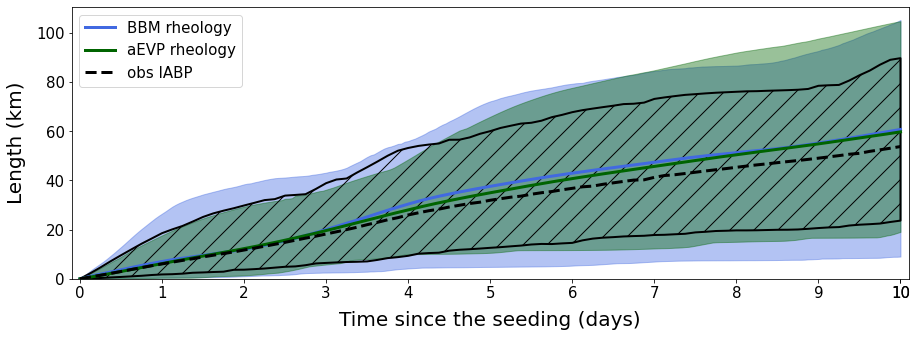

In [21]:
#Time series of the mean length over buoys => summarised all periods in a figure

##Choose the kind of figure we want

possible_std=["010"]
atmos_interest="BLK"

    ##Select the experiments for the figure(s)
exp_fig=[[] for _ in range(len(possible_std))]
for iexp in range(len(exp_interest)): #iteration over the experiments of interest
    pos_std_exp=np.where(np.array(possible_std)==exp_interest[iexp][-3:])[0]
    if len(pos_std_exp)==1 and atmos_interest in exp_interest[iexp]:
        exp_fig[pos_std_exp[0]].append(iexp)

    ##Removing the empty sublists, if any
print(exp_interest)
print(exp_fig,possible_std)
possible_std=[possible_std[ituple] for ituple in range(len(exp_fig)) if exp_fig[ituple]]
exp_fig=[exp_tuple for exp_tuple in exp_fig if exp_tuple]
print(exp_fig,possible_std)

##Some precomputations (mean, 5% and 95% quantiles)
data_mean=np.mean(Length_traj_simubuoys_mixall,axis=Length_traj_simubuoys_mixall.get_axis_num("mixall"))
data_5percent=np.nanquantile(Length_traj_simubuoys_mixall,axis=Length_traj_simubuoys_mixall.get_axis_num("mixall"),q=0.05)
data_95percent=np.nanquantile(Length_traj_simubuoys_mixall,axis=Length_traj_simubuoys_mixall.get_axis_num("mixall"),q=0.95)

data_IABP_mean=np.mean(Length_traj_IABP_mixall,axis=Length_traj_IABP_mixall.get_axis_num("mixall"))
data_IABP_5percent=np.nanquantile(Length_traj_IABP_mixall,axis=Length_traj_IABP_mixall.get_axis_num("mixall"),q=0.05)
data_IABP_95percent=np.nanquantile(Length_traj_IABP_mixall,axis=Length_traj_IABP_mixall.get_axis_num("mixall"),q=0.95)

for ifig in range(len(exp_fig)):#iteration over the figures

    ##Creation of the figure
    fig,ax=plt.subplots(1,1,figsize=(15,5))

    #Plot the length for the simulated buoys
    for iexp in exp_fig[ifig]: #iteration over the experiments of interest
        
        color,label=libfig.fgraph_attributesv2(exp_interest[iexp],"rheo",type_label="model",focus_model="rheo")
        label="a"*(label=="EVP")+label+" rheology"

        ax.fill_between(tdays,data_5percent[iexp,:],data_95percent[iexp,:],color=color,ec=color,alpha=0.4,zorder=-1)#envelope 5%-95% quantiles
        ax.plot(tdays,data_mean[iexp,:],c=color,label=label,zorder=2,lw=3)#mean

    #Plot the length for the IABP buoys
    ax.fill_between(tdays_IABP,data_IABP_5percent,data_IABP_95percent,hatch="/",fc="None",ec="black",lw=2,zorder=1)#envelope 5%-95% quantiles
    ax.plot(tdays_IABP,data_IABP_mean,c="black",label="obs IABP",ls="--",lw=3,zorder=5)#mean
        
    ##Set up the axes
    ax.tick_params(axis="both",labelsize=15)

    if len(exp_fig)==1:
        ax.set_ylim(0,1.05*np.max([np.max(data_95percent[iexp]) for iexp in exp_fig[ifig]]))
    else:
        ax.set_ylim(0,1.05*np.max(data_95percent))
    
    ax.set_xlim(-0.1,10.1)
    ax.set_xticks(np.append(tdays[::24],10))
         ##legend of the axes
    ax.set_ylabel("Length (km)",fontsize=20,labelpad=10)   
    ax.set_xlabel("Time since the seeding (days)",fontsize=20,labelpad=10)

    ##Set up the legend
    ax.legend(fontsize=15,loc="upper left")

    plt.show()
    ##Saving the figure (change the path if needed)    
    #fig.savefig("/lustre/fsn1/projects/rech/cli/udf71br/figures_traj_new_exp/Length_traj_std"+possible_std[ifig]+"_"+atmos_interest+".png",\
    #    facecolor="white",edgecolor="none",bbox_inches="tight")

#### Distance between the barycentre of each experiment and the observations

In [22]:
#Computation of the distance

Dist_bary_obs=[] #initialisation of the list that will contain the distances, one DataArray per period

for iperiod in range(len(period_interest)):#iteration over the periods of interest
    #/!\ should be the same date for the simulated and real buoys (every 3 hours)
    Dist_bary_obs.append(lib4traj.fdistance(ellipse_carac[iperiod].mu[:,::3,:,0],ellipse_carac[iperiod].mu[:,::3,:,1],\
                                            pos_IABP[iperiod][:,:,0],pos_IABP[iperiod][:,:,1]))
    #As mu has a wrong (default) value for the first time index, we recompute the distance for the first time index
    Dist_bary_obs[-1][:,0,:]=lib4traj.fdistance(pos_simubuoys[iperiod][:,:,0,:,0].mean("mb"),pos_simubuoys[iperiod][:,:,0,:,1].mean("mb"),\
                                            pos_IABP[iperiod][0,:,0],pos_IABP[iperiod][0,:,1])
    
    print(np.shape(Dist_bary_obs[iperiod]),np.shape(ellipse_carac[iperiod].mu))
print(len(period_interest),len(Dist_bary_obs))

(6, 81, 16) (6, 241, 16, 2)
(6, 81, 15) (6, 241, 15, 2)
(6, 81, 15) (6, 241, 15, 2)
(6, 81, 13) (6, 241, 13, 2)
(6, 81, 13) (6, 241, 13, 2)
(6, 81, 10) (6, 241, 10, 2)
(6, 81, 8) (6, 241, 8, 2)
(6, 81, 11) (6, 241, 11, 2)
8 8


In [23]:
#Create a DataArray containing all the values of distance between barycenters and observations, mixing all the buoys for all the periods

Dist_bary_obs_mixall=xr.DataArray(np.zeros((len(exp_interest),size_time_IABP,np.sum(size_buoy)))+999.999,dims=["exp","time","mixall"])

for iperiod in range(len(period_interest)): #iteration over the periods of interest
    for iexp in range(len(exp_interest)): #iteration over the experiments of interest
        for it in range(size_time_IABP): #iteration over time        
            Dist_bary_obs_mixall[iexp,it,np.sum(size_buoy[:iperiod+1])-size_buoy[iperiod]:np.sum(size_buoy[:iperiod+1])]=\
                Dist_bary_obs[iperiod][iexp,it,:].values

print(np.shape(Dist_bary_obs_mixall))

(6, 81, 101)


['EBLKBBM001', 'EBLKBBM010', 'EBLKBBM050', 'EBLKEVP001', 'EBLKEVP010', 'EBLKEVP050']
[[1, 4]] ['010']
[[1, 4]] ['010']


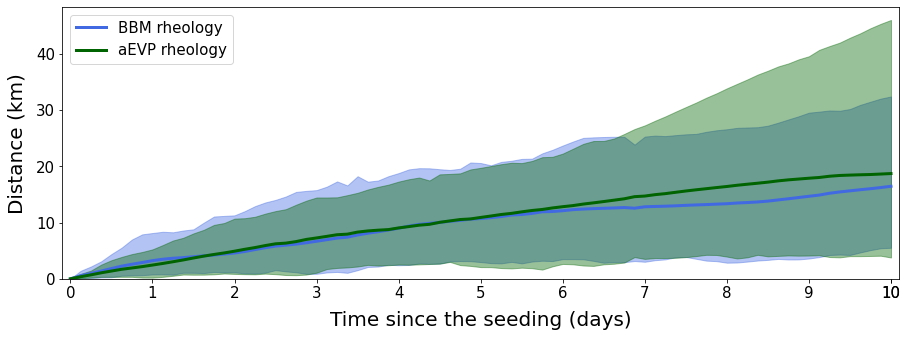

In [24]:
#Time series of the mean distance between barycenters and observations => summarised all periods in a figure

##Choose of the kind of figure we want

possible_std=["010"]
atmos_interest="BLK"

    ##Select the experiments for the figure(s)
exp_fig=[[] for _ in range(len(possible_std))]
for iexp in range(len(exp_interest)):
    pos_std_exp=np.where(np.array(possible_std)==exp_interest[iexp][-3:])[0]
    if len(pos_std_exp)==1 and atmos_interest in exp_interest[iexp]:
        exp_fig[pos_std_exp[0]].append(iexp)
        
    ##Removing the empty sublists, if any
print(exp_interest)
print(exp_fig,possible_std)
possible_std=[possible_std[ituple] for ituple in range(len(exp_fig)) if exp_fig[ituple]]
exp_fig=[exp_tuple for exp_tuple in exp_fig if exp_tuple]
print(exp_fig,possible_std)

##Some precomputation (mean, 5% and 95% quantiles)
data_mean=np.mean(Dist_bary_obs_mixall,axis=Dist_bary_obs_mixall.get_axis_num("mixall"))
data_5percent=np.nanquantile(Dist_bary_obs_mixall,axis=Dist_bary_obs_mixall.get_axis_num("mixall"),q=0.05)
data_95percent=np.nanquantile(Dist_bary_obs_mixall,axis=Dist_bary_obs_mixall.get_axis_num("mixall"),q=0.95)

for ifig in range(len(exp_fig)): #iteration over the figures

    ##Creation of the figure
    fig,ax=plt.subplots(1,1,figsize=(15,5))

    for iexp in exp_fig[ifig]: #iteration over the experiments of interest
        
        color,label=libfig.fgraph_attributesv2(exp_interest[iexp],"rheo",type_label="model",focus_model="rheo")
        label="a"*(label=="EVP")+label+" rheology"

        ax.fill_between(tdays_IABP,data_5percent[iexp,:],data_95percent[iexp,:],color=color,ec=color,alpha=0.4,zorder=-1)#envelope 5%-95% quantiles
        ax.plot(tdays_IABP,data_mean[iexp,:],c=color,label=label,zorder=2,lw=3)#mean
    
    ##Set up the axes
    ax.tick_params(axis="both",labelsize=15)
    if len(exp_fig)==1:
        ax.set_ylim(0,1.05*np.max([np.max(data_95percent[iexp]) for iexp in exp_fig[ifig]]))
    else:
        ax.set_ylim(0,1.05*np.max(data_95percent))
    
    ax.set_xlim(-0.1,10.1)
    ax.set_xticks(np.append(tdays[::24],10))   
         ##legend of the axes
    ax.set_ylabel("Distance (km)",fontsize=20,labelpad=10)   
    ax.set_xlabel("Time since the seeding (days)",fontsize=20,labelpad=10)

    ##Set up a legend
    ax.legend(fontsize=15,loc="upper left")

    plt.show()
    ##Saving the figure (change the path if needed)
    #fig.savefig("/lustre/fsn1/projects/rech/cli/udf71br/figures_traj_new_exp/Dist_bary_obs_std"+possible_std[ifig]+"_"+atmos_interest+".png",\
    #    facecolor="white",edgecolor="none",bbox_inches="tight")

#### Angle between IABP trajectories and the simulated ones

In [25]:
#Computation of the angle between IABP trajectories and the simulated ones

##Initialisation
Angle_simu_obs=[xr.DataArray(data=np.zeros((len(exp_interest),size_time_IABP,size_buoy[iperiod]))+99999.99,dims=["exp","time","buoy"]) for iperiod in range(len(period_interest))] #initialisation of the list that will contain the angles, one DataArray per period

##Computation
for iperiod in range(len(period_interest)):#iteration over the periods of interest
    
    ##Seeding instant
    Angle_simu_obs[iperiod][:,0,:]=0.
    
    for ib in dat_IABP[iperiod].buoy: #iteration over the buoys
        
        pos_seed=pos_IABP[iperiod][0,ib,:] #seeding position
        
        for it in range(1,size_time_IABP): #iteration over time
            
            #/!\ should be the same date for the simulated and real buoys (every 3 hours)
            
            for iexp in range(len(exp_interest)): #iteration over the experiments
                
                lineA=[[pos_seed[0],pos_seed[1]],[ellipse_carac[iperiod].mu[iexp,it*3,ib,0],ellipse_carac[iperiod].mu[iexp,it*3,ib,1]]]
                lineB=[[pos_seed[0],pos_seed[1]],[pos_IABP[iperiod][it,ib,0],pos_IABP[iperiod][it,ib,1]]]
                Angle_simu_obs[iperiod][iexp,it,ib]=sit.ang(lineA,lineB)[0]

    print(np.shape(Angle_simu_obs[iperiod]))
print(len(Angle_simu_obs))

(6, 81, 16)
(6, 81, 15)
(6, 81, 15)
(6, 81, 13)
(6, 81, 13)
(6, 81, 10)
(6, 81, 8)
(6, 81, 11)
8


In [26]:
#Create a DataArray containing all the values of the angle between barycenters and observations, mixing all the buoys for all the periods

Angle_simu_obs_mixall=xr.DataArray(np.zeros((len(exp_interest),size_time_IABP,np.sum(size_buoy)))+999.999,dims=["exp","time","mixall"])

for iperiod in range(len(period_interest)): #iteration over the periods of interest
    for iexp in range(len(exp_interest)): #iteration over the experiments of interest
        for it in range(size_time_IABP): #iteration over time        
            Angle_simu_obs_mixall[iexp,it,np.sum(size_buoy[:iperiod+1])-size_buoy[iperiod]:np.sum(size_buoy[:iperiod+1])]=\
                Angle_simu_obs[iperiod][iexp,it,:].values

print(np.shape(Angle_simu_obs_mixall))

(6, 81, 101)


['EBLKBBM001', 'EBLKBBM010', 'EBLKBBM050', 'EBLKEVP001', 'EBLKEVP010', 'EBLKEVP050']
[[1, 4]] ['010']
[[1, 4]] ['010']


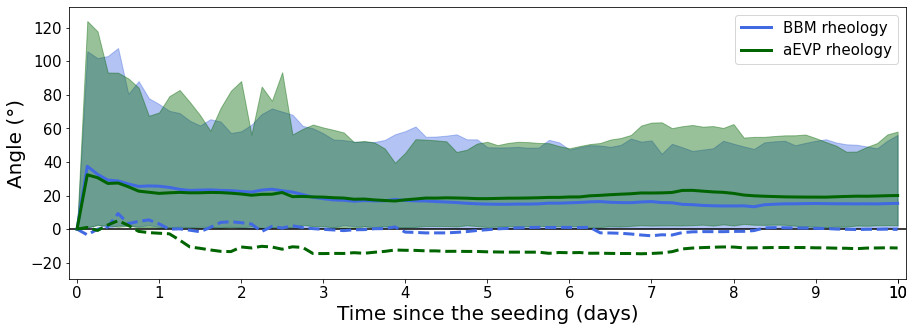

In [27]:
#Time series of the mean angle between barycenters and observations => summarised all periods in a figure

##Choose of the kind of figure we want

possible_std=["010"]
atmos_interest="BLK"

    ##Select the experiments for the figure(s)
exp_fig=[[] for _ in range(len(possible_std))]
for iexp in range(len(exp_interest)):
    pos_std_exp=np.where(np.array(possible_std)==exp_interest[iexp][-3:])[0]
    if len(pos_std_exp)==1 and atmos_interest in exp_interest[iexp]:
        exp_fig[pos_std_exp[0]].append(iexp)
        
    ##Removing the empty sublists, if any
print(exp_interest)
print(exp_fig,possible_std)
possible_std=[possible_std[ituple] for ituple in range(len(exp_fig)) if exp_fig[ituple]]
exp_fig=[exp_tuple for exp_tuple in exp_fig if exp_tuple]
print(exp_fig,possible_std)

##Some precomputation (mean (abs or not), 5% and 95% quantiles)
data_mean=np.mean(np.abs(Angle_simu_obs_mixall),axis=Angle_simu_obs_mixall.get_axis_num("mixall"))
data_5percent=np.nanquantile(np.abs(Angle_simu_obs_mixall),axis=Angle_simu_obs_mixall.get_axis_num("mixall"),q=0.05)
data_95percent=np.nanquantile(np.abs(Angle_simu_obs_mixall),axis=Angle_simu_obs_mixall.get_axis_num("mixall"),q=0.95)
data_mean_signs=np.mean(Angle_simu_obs_mixall,axis=Angle_simu_obs_mixall.get_axis_num("mixall"))

for ifig in range(len(exp_fig)): #iteration over the figures

    ##Creation of the figure
    fig,ax=plt.subplots(1,1,figsize=(15,5))

    for iexp in exp_fig[ifig]: #iteration over the experiments of interest
        
        color,label=libfig.fgraph_attributesv2(exp_interest[iexp],"rheo",type_label="model",focus_model="rheo")
        label="a"*(label=="EVP")+label+" rheology"

        ax.fill_between(tdays_IABP,data_5percent[iexp,:],data_95percent[iexp,:],color=color,ec=color,alpha=0.4,zorder=-1)#envelope 5%-95% quantiles
        ax.plot(tdays_IABP,data_mean[iexp,:],c=color,label=label,zorder=2,lw=3)#mean absolute value

        ax.plot(tdays_IABP,data_mean_signs[iexp,:],c=color,zorder=5,lw=3,ls="--")#mean

    ax.plot([-0.2,10.2],[0,0],c="black",zorder=0)
    
    ##Set up the axes
    ax.tick_params(axis="both",labelsize=15)
    ax.set_ylim(2*np.min(data_mean_signs),1.05*np.max(data_95percent))
    ax.set_xlim(-0.1,10.1)
    ax.set_xticks(np.append(tdays[::24],10))
         ##legend of the axes
    ax.set_ylabel("Angle (°)",fontsize=20)   
    ax.set_xlabel("Time since the seeding (days)",fontsize=20)

    ##Set up the legend
    ax.legend(fontsize=15,loc="upper right")

    plt.show()
    ##Saving the figure (change the path if needed)
    #fig.savefig("/lustre/fsn1/projects/rech/cli/udf71br/figures_traj_new_exp/Angle_simu_obs_abs_std"+possible_std[ifig]+"_"+atmos_interest+".png",\
    #    facecolor="white",edgecolor="none",bbox_inches="tight")

### Spread of the simulated trajectories (area of the ellipses)

If we have A, a matrix, and U, an eigenvector associated with the eigenvalue $\lambda$. We have so $A U = \lambda U$. So A and $\lambda$ have the same unit (the unit of U doesn't matter). In our case, A is the covariance matrix of $X_1$ and $X_2$ that are x- and y-point positions in km. So our eigenvalues are in $\mathrm{km^2}$. The length of our axes is computed by taking the square root of the eigenvalues, so the length of the axes is in km. As the area is computed as: $\pi \times length axis 1 \times length axis 2 \times 0.25$, the area is in $\mathrm{km^2}$.

In [28]:
#Computation of the area of the ellipses

##Initialisation
Area_ellipse=[]

##Computation
for iperiod in range(len(period_interest)):#iteration over the periods of interest
    Area_ellipse.append(np.pi*ellipse_carac[iperiod].axlength[:,:,:,0]*ellipse_carac[iperiod].axlength[:,:,:,1]*0.25)
    Area_ellipse[iperiod][:,0,:]=0
    print(np.shape(Area_ellipse[iperiod]),np.shape(ellipse_carac[iperiod].axlength))

print(len(Area_ellipse))

(6, 241, 16) (6, 241, 16, 2)
(6, 241, 15) (6, 241, 15, 2)
(6, 241, 15) (6, 241, 15, 2)
(6, 241, 13) (6, 241, 13, 2)
(6, 241, 13) (6, 241, 13, 2)
(6, 241, 10) (6, 241, 10, 2)
(6, 241, 8) (6, 241, 8, 2)
(6, 241, 11) (6, 241, 11, 2)
8


In [29]:
#Create a DataArray containing all the values of the area of the ellipses, mixing all the buoys for all the periods

Area_ellipse_mixall=xr.DataArray(np.zeros((len(exp_interest),size_time,np.sum(size_buoy)))+999.999,dims=["exp","time","mixall"])

for iperiod in range(len(period_interest)): #iteration over the periods of interest
    for iexp in range(len(exp_interest)): #iteration over the experiments of interest
        for it in range(size_time): #iteration over time        
            Area_ellipse_mixall[iexp,it,np.sum(size_buoy[:iperiod+1])-size_buoy[iperiod]:np.sum(size_buoy[:iperiod+1])]=\
                Area_ellipse[iperiod][iexp,it,:].values

print(np.shape(Area_ellipse_mixall))

(6, 241, 101)


['EBLKBBM001', 'EBLKBBM010', 'EBLKBBM050', 'EBLKEVP001', 'EBLKEVP010', 'EBLKEVP050']
[[0, 1, 2], [3, 4, 5]] ['001', '010', '050']
[[0, 1, 2], [3, 4, 5]] ['001', '010', '050']


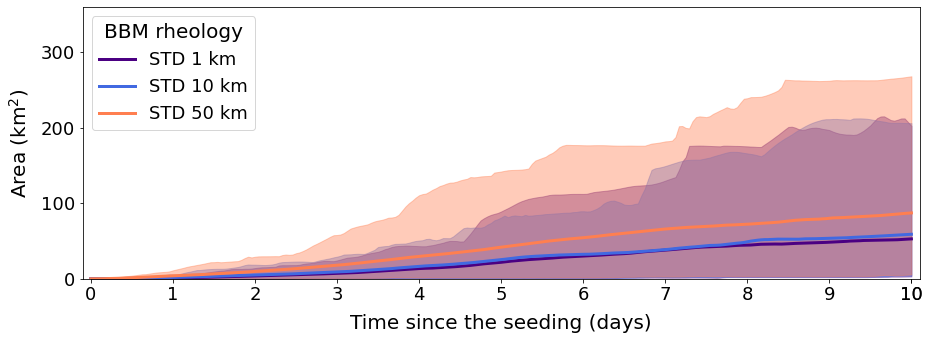

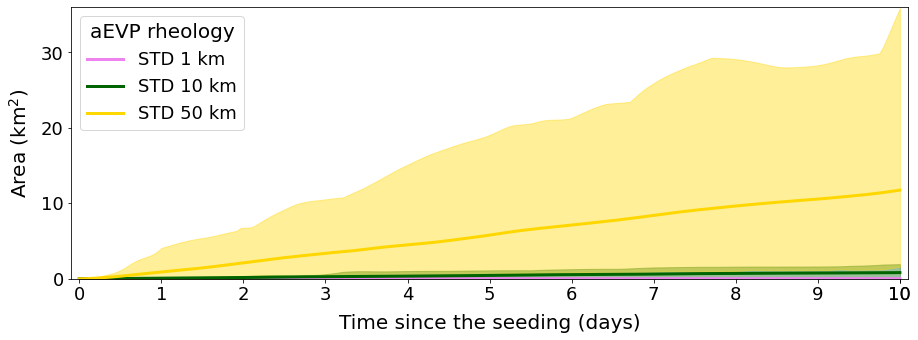

In [30]:
#Time series of the mean area over buoys => summarised all periods in a figure

##Choose the kind of figure we want
possible_std=["001","010","050"]
possible_rheo=["BBM","EVP"]
type_atmos="BLK"

    ##Select the experiments for the figures
exp_fig=[[] for _ in range(len(possible_rheo))]
for iexp in range(len(exp_interest)):
    if type_atmos+possible_rheo[0] in exp_interest[iexp]:
        exp_fig[0].append(iexp)
    elif type_atmos+possible_rheo[1] in exp_interest[iexp]:
        exp_fig[1].append(iexp)

print(exp_interest)
print(exp_fig,possible_std)
    ##Removing the empty sublists, if any
exp_fig=[exp_tuple for exp_tuple in exp_fig if exp_tuple]
print(exp_fig,possible_std)

##Some precomputations (mean, 5% and 95% quantiles)

data_mean=np.mean(Area_ellipse_mixall,axis=Area_ellipse_mixall.get_axis_num("mixall"))
data_5percent=np.nanquantile(Area_ellipse_mixall,axis=Area_ellipse_mixall.get_axis_num("mixall"),q=0.05)
data_95percent=np.nanquantile(Area_ellipse_mixall,axis=Area_ellipse_mixall.get_axis_num("mixall"),q=0.95)

for ifig in range(len(exp_fig)):#iteration over the figures

    ##Creation of the figure
    fig,ax=plt.subplots(1,1,figsize=(15,5))

    ##Label of the figure
    label_fig=type_atmos+"+"+possible_rheo[ifig]

    ##Plot the time series of the area of the ellipses
    for iexp in exp_fig[ifig]: #iteration over the experiments of interest

        #color and label associated with the experiment of interest
        color,label=libfig.fgraph_attributesv2(exp_interest[iexp],"rheo",type_label="full",focus_model="rheo")
                
        ##Set up the legend labels
        label=""+str.strip(label[-9:])
        label_title="a"*(possible_rheo[ifig]=="EVP")+possible_rheo[ifig]+" rheology"

        ax.fill_between(tdays,data_5percent[iexp,:],data_95percent[iexp,:],color=color,ec=color,alpha=0.4,zorder=-1)#envelope 5%-95% quantiles           
        ax.plot(tdays,data_mean[iexp,:],c=color,label=label,zorder=2,lw=3)#mean
        
    ##Set up the axes
    ax.tick_params(axis="both",labelsize=18)
    ax.set_xlim(-0.1,10.1)
    ax.set_xticks(np.append(tdays[::24],10))

        ##/!\ done manually, will not work for all kinds of figures!!!
    if possible_rheo[ifig]=="BBM":
        ax.set_ylim(0,360)
    elif possible_rheo[ifig]=="EVP":
        ax.set_ylim(0,36)
    
        ##Legend of the axes
    ax.set_ylabel("Area ("+r"$\mathrm{km^2}$"+")",fontsize=20,labelpad=10)
    ax.set_xlabel("Time since the seeding (days)",fontsize=20,labelpad=10)
    
    ##Legend of the curves
    legBBM=ax.legend(fontsize=18,loc="upper left",title=label_title,title_fontsize=20)
   
    plt.show()
    ##Saving the figure (change the path if needed)
    #fig.savefig("/lustre/fsn1/projects/rech/cli/udf71br/figures_traj_new_exp/Area_ellipse_"+label_fig+".png",\
    #    facecolor="white",edgecolor="none",bbox_inches="tight")